<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pricing-and-hedging-under-the-Black-Scholes-model" data-toc-modified-id="Pricing-and-hedging-under-the-Black-Scholes-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pricing and hedging under the Black-Scholes model</a></span><ul class="toc-item"><li><span><a href="#Simulate-several-paths-of-the-stock-price." data-toc-modified-id="Simulate-several-paths-of-the-stock-price.-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Simulate several paths of the stock price.</a></span></li><li><span><a href="#Plot-the-value-of-the-call-option-as-a-function-of-time-using-one-of-the-paths-obtained-in-1.1" data-toc-modified-id="Plot-the-value-of-the-call-option-as-a-function-of-time-using-one-of-the-paths-obtained-in-1.1-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Plot the value of the call option as a function of time using one of the paths obtained in 1.1</a></span></li><li><span><a href="#Plot-the-value-of-the-hedging-portfolio-assuming-that-it-has-been-rebalanced-daily.-Plot-the-hedging-error." data-toc-modified-id="Plot-the-value-of-the-hedging-portfolio-assuming-that-it-has-been-rebalanced-daily.-Plot-the-hedging-error.-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Plot the value of the hedging portfolio assuming that it has been rebalanced daily. Plot the hedging error.</a></span></li></ul></li><li><span><a href="#Implied-volatilities" data-toc-modified-id="Implied-volatilities-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Implied volatilities</a></span><ul class="toc-item"><li><span><a href="#Compute-the-implied-volatility-using-Newton's-method" data-toc-modified-id="Compute-the-implied-volatility-using-Newton's-method-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Compute the implied volatility using Newton's method</a></span></li><li><span><a href="#Plot-volatility-surface" data-toc-modified-id="Plot-volatility-surface-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Plot volatility surface</a></span></li></ul></li></ul></div>

# Pricing and hedging under the Black-Scholes model

In [4]:
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt  
from scipy.stats import norm
from scipy.integrate import quad
from sklearn.preprocessing import MinMaxScaler

##  Simulate several paths of the stock price.

In [48]:
# vol func and intergeal 
def vol(time):
    s = 0.17**2*1/12+0.15**2*(2/12)+0.13**2*(2/12)+0.12**2*1/12
    sigma = 0
    intergral = 0 
    if time < 1/12:
        sigma = 0.12
        intergral = s-(time*0.12**2)
    elif time < 3/12:
        sigma = 0.13
        intergral = s-(1/12*0.12**2 +(time-1/12)*0.13**2)
    elif time < 5/12:
        sigma = 0.15
        intergral = s-(1/12*0.12**2 + 2/12*0.13**2+ (time-3/12)*0.15**2)
    else:
        sigma = 0.17
        intergral = s-(1/12*0.12**2 + 2/12*0.13**2 + 2/12*0.15**2 + (time-5/12)*0.17**2)
    return(sigma,intergral)

In [59]:
def stock_plot(S_0, rate, steps, mat, num_sim):
    S0, r, N, T, I = S_0, rate, steps, mat, num_sim  #I: number of replicates per scenario
    dt = T/N
    S = np.zeros((N+1 ,I)) 
    S[0] = S0 

    for j in range(1,N+1):  
        sigma = vol(j*dt)[0]
        S[j] = S[j-1] + sigma*S[j-1]*np.random.normal(scale=np.sqrt(dt), size=I)+r*S[j-1]*dt 

    return(pd.DataFrame(S))

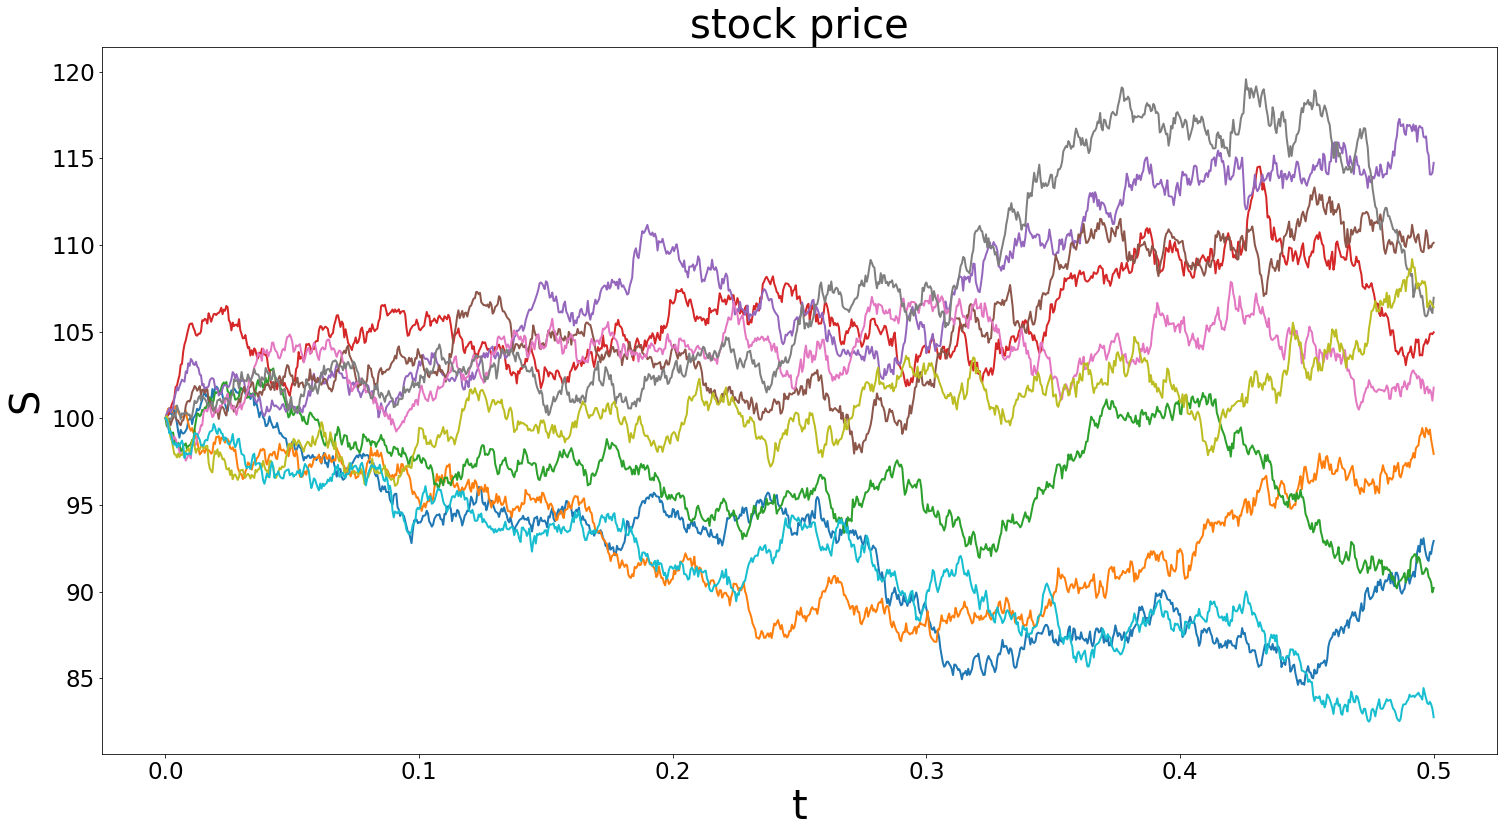

In [60]:
S = stock_plot(100, 0.05, 1000, 1/2, 10)
plt.figure(figsize=(25,13))         
plt.plot(S.rename(index = lambda x: x*0.5/1000),lw = 2)
plt.xlabel('t',fontsize=40)  
plt.ylabel('S',fontsize=40)  
plt.title('stock price',fontsize=40)
plt.tick_params(labelsize=23)
plt.show()

## Plot the value of the call option as a function of time using one of the paths obtained in 1.1

In [61]:
def option_plot(path, struck): # path: choose a stock path 
    N = 1000
    r = 0.05
    T =1/2
    dt = T/N
    stock = S[int(path-1)]
    K = struck
    call = np.zeros((N+1,1))
    deltas = np.zeros((N+1,1))
    for j in range(0,N+1):
        if j == N:
            call[j] = max(stock[j]-K,0)
            deltas[j] = np.nan
        else:
            # im_sigma = np.sqrt(vol(j*dt)[1])/float((1/2-j*dt))
            im_sigma = np.sqrt(float(vol(j*dt)[1])/float((1/2-j*dt)))
            d1 = (np.log(stock[j]/K)+(r+1/2*im_sigma**2)*(1/2-j*dt))/(im_sigma*np.sqrt(1/2-j*dt))
            deltas[j] = norm.cdf(d1) 
            d2 = (np.log(stock[j]/K)+(r-1/2*im_sigma**2)*(1/2-j*dt))/(im_sigma*np.sqrt(1/2-j*dt))  
            call[j]=stock[j]*norm.cdf(d1)-K*np.exp(-r*(1/2-j*dt))*norm.cdf(d2)

    scaler = MinMaxScaler(feature_range=(np.min(call), np.max(call)))
    scaled_stock = scaler.fit_transform(pd.DataFrame(stock))
    prices = pd.DataFrame(data = np.hstack((deltas, pd.DataFrame(stock),scaled_stock, call)), 
                          columns=["deltas", "stock price","scaled stock","call option price"])
    
    return(prices)

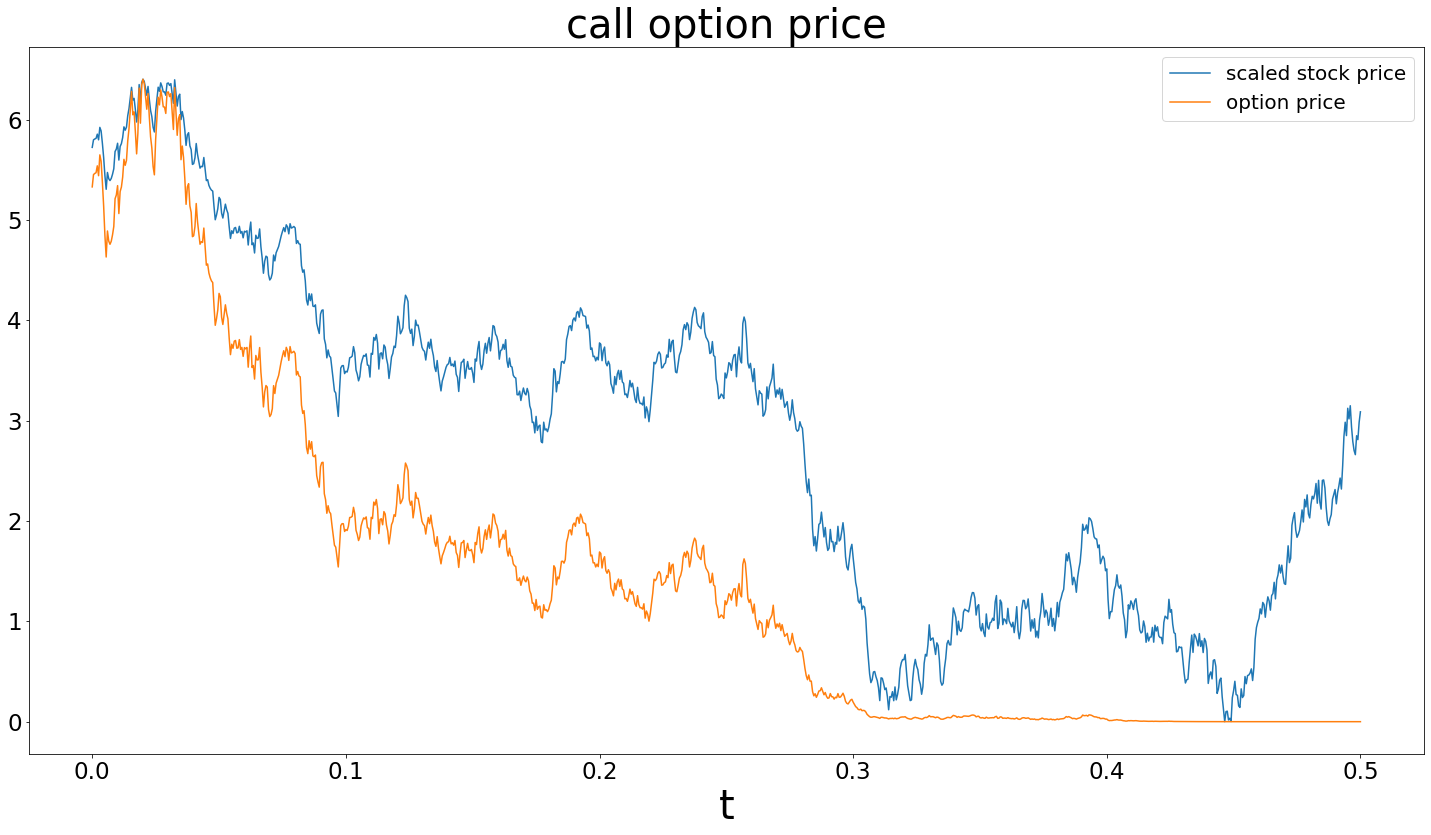

,deltas,stock price,scaled stock,call option price
996,7.937144e-30,91.767553,2.660478,4.830336e-31
997,1.607966e-34,92.274340,2.848971,7.900837e-36
998,3.589736e-52,92.170696,2.810422,1.163374e-53
999,2.850720e-90,92.636466,2.983659,4.965810e-92
1000,NaN,92.915714,3.087522,0.000000e+00


In [68]:
prices = option_plot(1,100)

plt.figure(figsize=(25,13))  
plt.plot(prices.rename(index = lambda x: x *0.5/1000 ) ["scaled stock"],lw = 1.5, label="scaled stock price")
plt.plot(prices.rename(index = lambda x: x *0.5/1000 ) ["call option price"],lw = 1.5, label="option price")
plt.xlabel('t',fontsize=40)  
plt.ylabel('',fontsize=40)  
plt.title('call option price',fontsize=40)
plt.tick_params(labelsize=23)
plt.legend(loc = 'upper right',fontsize=20)
plt.show()

#prices[0:50]
prices[-5:]

## Plot the value of the hedging portfolio assuming that it has been rebalanced daily. Plot the hedging error.

In [69]:
 def hedge_err(step): 
    r = 0.05
    N = 1000
    T =1/2
    dt = T/N
    
    v = np.zeros(N+1)
    delta = np.zeros(N+1)
    v[0] = prices["call option price"][0]
    deltas = prices["deltas"]
    stock = prices["stock price"]
    
    h = step 
    
    for i in range(0, int(h)+1):
        delta[round(i*N/h):round((i+1)*N/h)] = deltas[round(i*N/h)] # choose the closest time
    
    for j in range(1,N+1):
        v[j]=v[j-1]+delta[j-1]*(stock[j]-stock[j-1])+(np.exp(r*dt)-1)*(v[j-1]-delta[j-1]*stock[j-1])
    
    errinfo = pd.DataFrame(data= v-prices["call option price"].values, columns=["hedging error"])
    errinfo["conti deltas"]=prices["deltas"]
    errinfo["step deltas"]= delta
    errinfo[("call option price")]=prices["call option price"]
    errinfo["portfolio value"]=v
    return(errinfo)

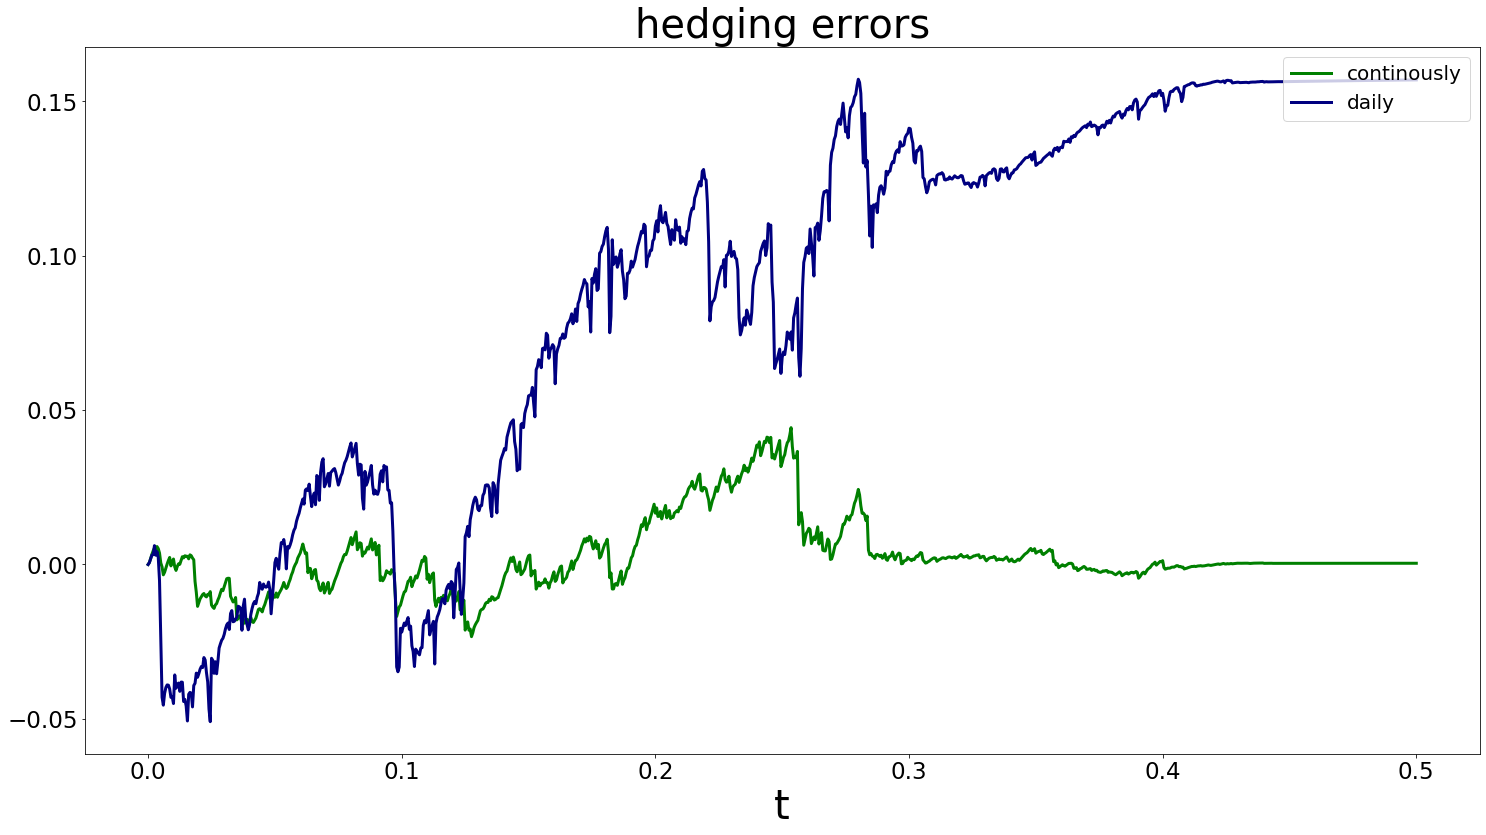

In [71]:
# continously hedging errors
error1= hedge_err(1000)    

# daily hedging erros
error2= hedge_err(180)  

plt.figure(figsize=(25,13))   
plt.plot(error1.rename(index = lambda x: x *0.5/1000)["hedging error"],lw = 3, color="green", label="continously")
plt.plot(error2.rename(index = lambda x: x *0.5/1000)["hedging error"],lw = 3, color="navy", label="daily")


plt.xlabel('t',fontsize=40)  
plt.ylabel('',fontsize=40)  
plt.title('hedging errors',fontsize=40)
plt.legend(loc='upper right',fontsize=20)
plt.tick_params(labelsize=23)
plt.show()


# Implied volatilities

## Compute the implied volatility using Newton's method

In [42]:
df = pd.read_excel('ito_call_data.xlsx', index_col= None)
df['Maturity'] = df['Maturity'].map(lambda x: x/365)
df.head()

,Maturity,Strike,Spot,r,c_prem
0,0.068493,42.5,42.27,0.0492,2.70
1,0.164384,42.5,42.27,0.0485,3.90
2,0.413699,42.5,42.27,0.0491,4.80
3,0.068493,45.0,42.27,0.0492,1.25
4,0.164384,45.0,42.27,0.0485,2.40


In [43]:
# Newton
interation_num = 2000

def newton(params):
    solutionFound = False  # Have not converged to a solution yet
    
    T, K, S, r, C = params[0], params[1], params[2], params[3], params[4]
    
    x = np.zeros(interation_num+1) 
    m = S/(K*np.exp(-r*T))
    x0 = np.sqrt(2*np.abs(np.log(m))/T)
    x[0] = x0 
 
    
    for i in range(1,interation_num+1):
        d1 = (np.log(S/K)+(r+1/2*x[i-1]**2)*T)/(x[i-1]*np.sqrt(T))
        d2 = (np.log(S/K)+(r-1/2*x[i-1]**2)*T)/(x[i-1]*np.sqrt(T))
        f = S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)-C
        fprime = S*norm.pdf(d1)*np.sqrt(T)
        x[i]=x[i-1]-f/fprime 
        print("İteration:", i, "Market - BS:", x[i] - x[i-1])
        
        if abs(x[i] - x[i-1])< 1e-15:
            solutionFound = True
            solution = x[i]
            break

    if solutionFound == True :
        print("Early Stoppin!", "\n", 
                 "Model Price:", round(x[i],2), "Market Price:", x[i-1])
        return solution  # x is a solution within tolerance and maximum number of iterations
    else:
        print("Did not converge")  # Newton's method did not converge


In [44]:
vol = []
for i in range(0, df.shape[0]):
        l = df.iloc[i].values.reshape(-1).tolist()
        vol.append(newton(l))

İteration: 1 Market - BS: 0.37624992809435365
İteration: 2 Market - BS: 0.0003324136308033854
İteration: 3 Market - BS: 5.736765507080577e-10
İteration: 4 Market - BS: 2.220446049250313e-16
Early Stoppin! 
 Model Price: 0.62 Market Price: 0.621638808177291
İteration: 1 Market - BS: 0.3876864336481252
İteration: 2 Market - BS: 0.0007758049674749801
İteration: 3 Market - BS: 6.9084398202079456e-09
İteration: 4 Market - BS: -8.881784197001252e-16
Early Stoppin! 
 Model Price: 0.56 Market Price: 0.5644680793894291
İteration: 1 Market - BS: 0.14901448606560908
İteration: 2 Market - BS: 0.00016740222618299994
İteration: 3 Market - BS: 5.015318715884121e-10
İteration: 4 Market - BS: 2.7755575615628914e-16
Early Stoppin! 
 Model Price: 0.42 Market Price: 0.417446895820379
İteration: 1 Market - BS: -0.7927319772073338
İteration: 2 Market - BS: -0.012774091902666207
İteration: 3 Market - BS: -2.943284102485677e-05
İteration: 4 Market - BS: -1.6394940960395843e-10
İteration: 5 Market - BS: 0.0
Ea

## Plot volatility surface

In [45]:
df["implied_vol"] = vol
df["Firms"]=np.nan
df["Firms"][df.Spot == 42.27] = "Duke"
df["Firms"][df.Spot == 108.9] = "IBM"
df["Firms"][df.Spot == 55.1875] = "Microsoft"
df.head()

/Users/yaping/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/yaping/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Maturity,Strike,Spot,r,c_prem,implied_vol,Firms
0,0.068493,42.5,42.27,0.0492,2.70,0.621639,Duke
1,0.164384,42.5,42.27,0.0485,3.90,0.564468,Duke
2,0.413699,42.5,42.27,0.0491,4.80,0.417447,Duke
3,0.068493,45.0,42.27,0.0492,1.25,0.509409,Duke
4,0.164384,45.0,42.27,0.0485,2.40,0.492843,Duke


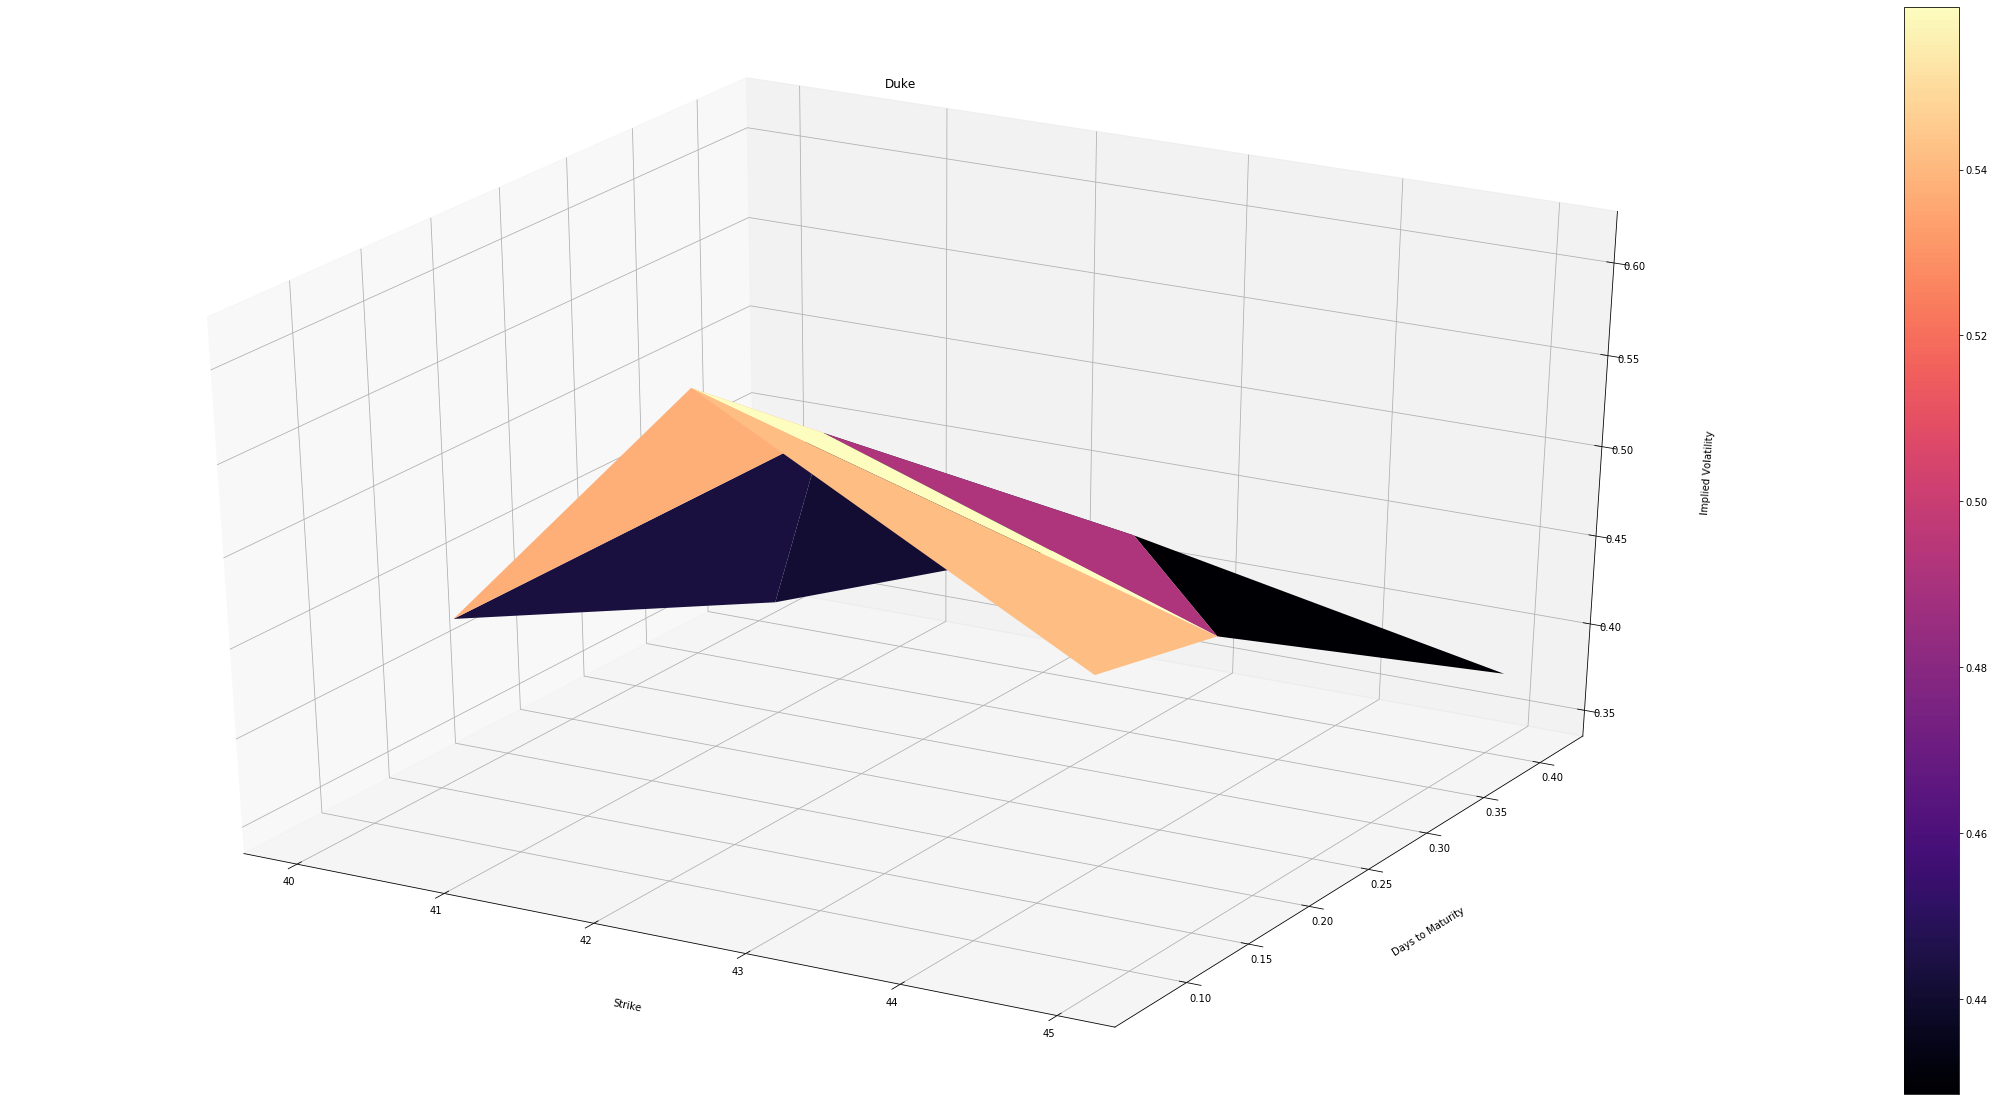

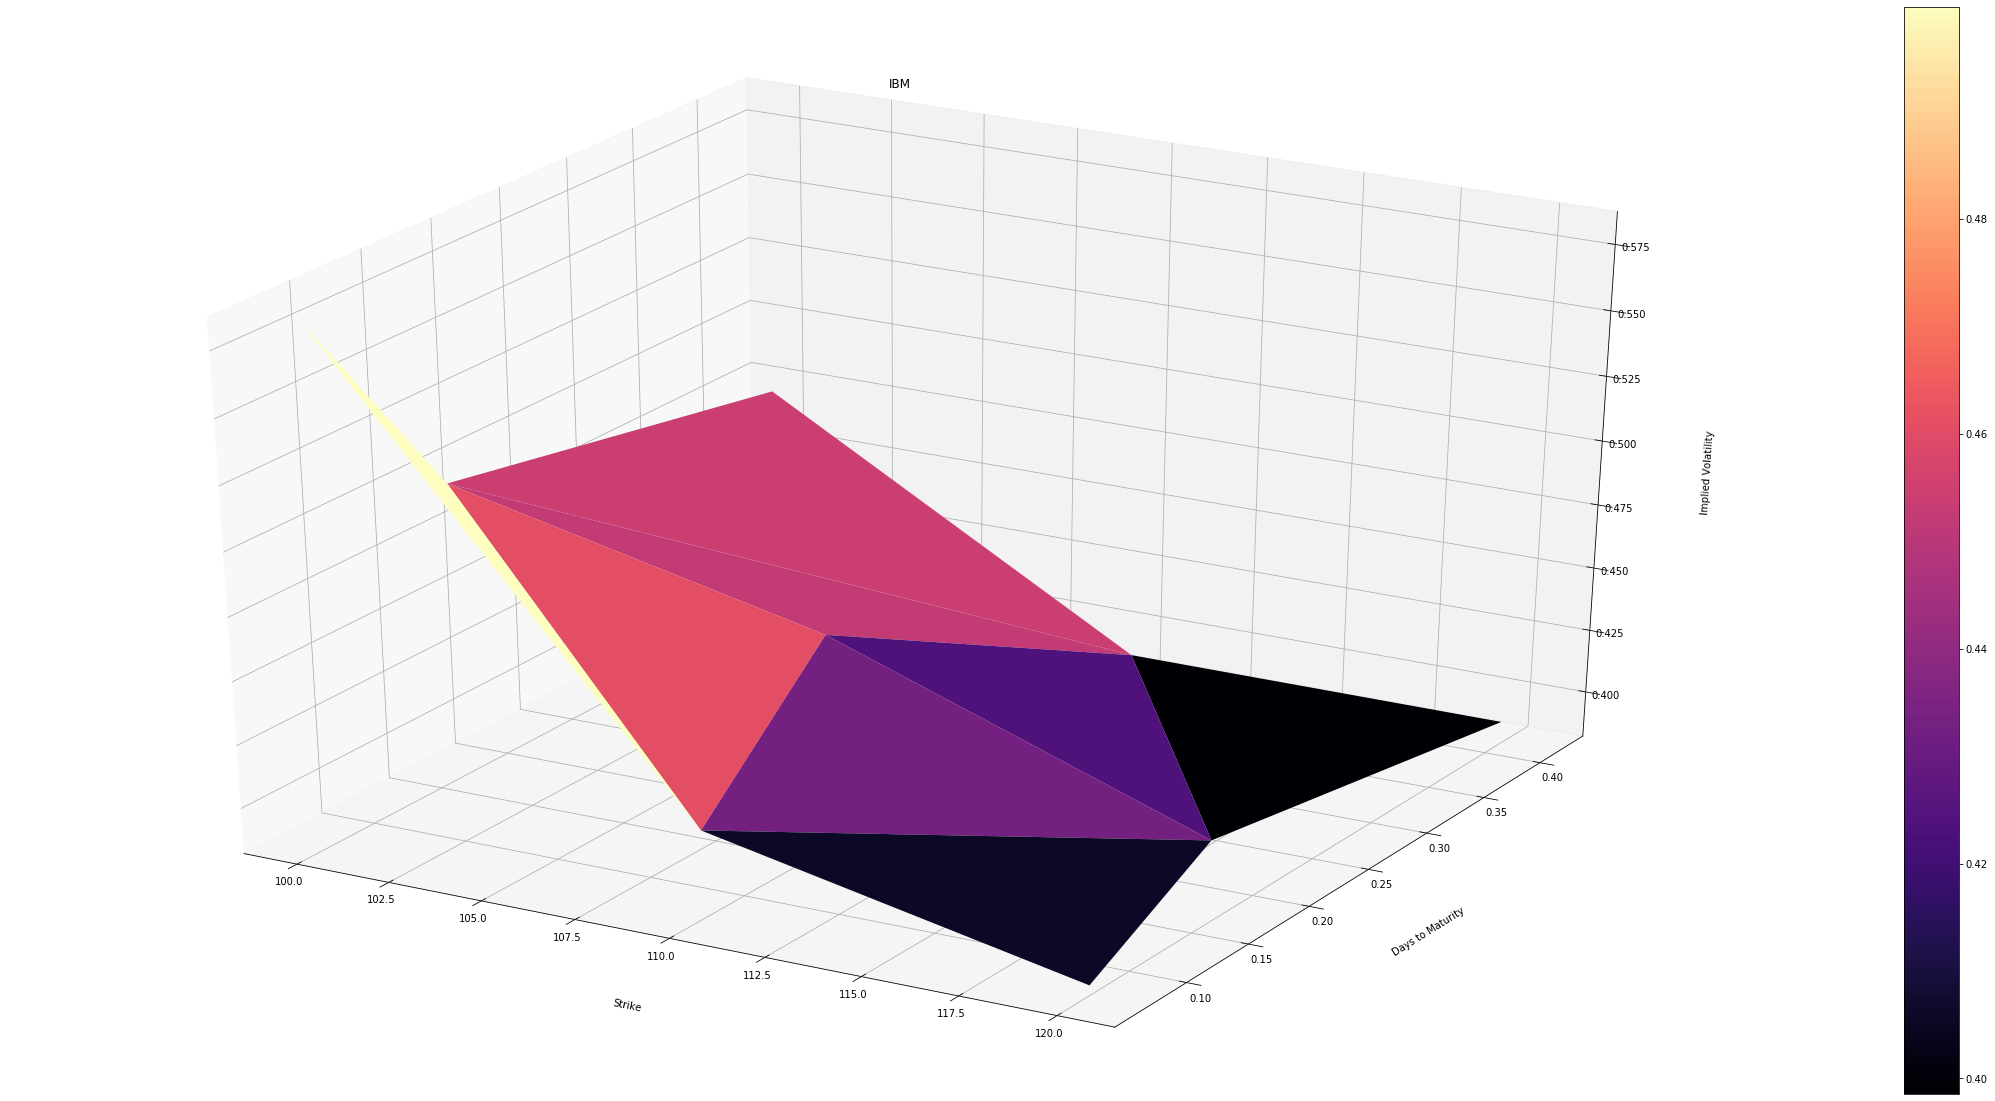

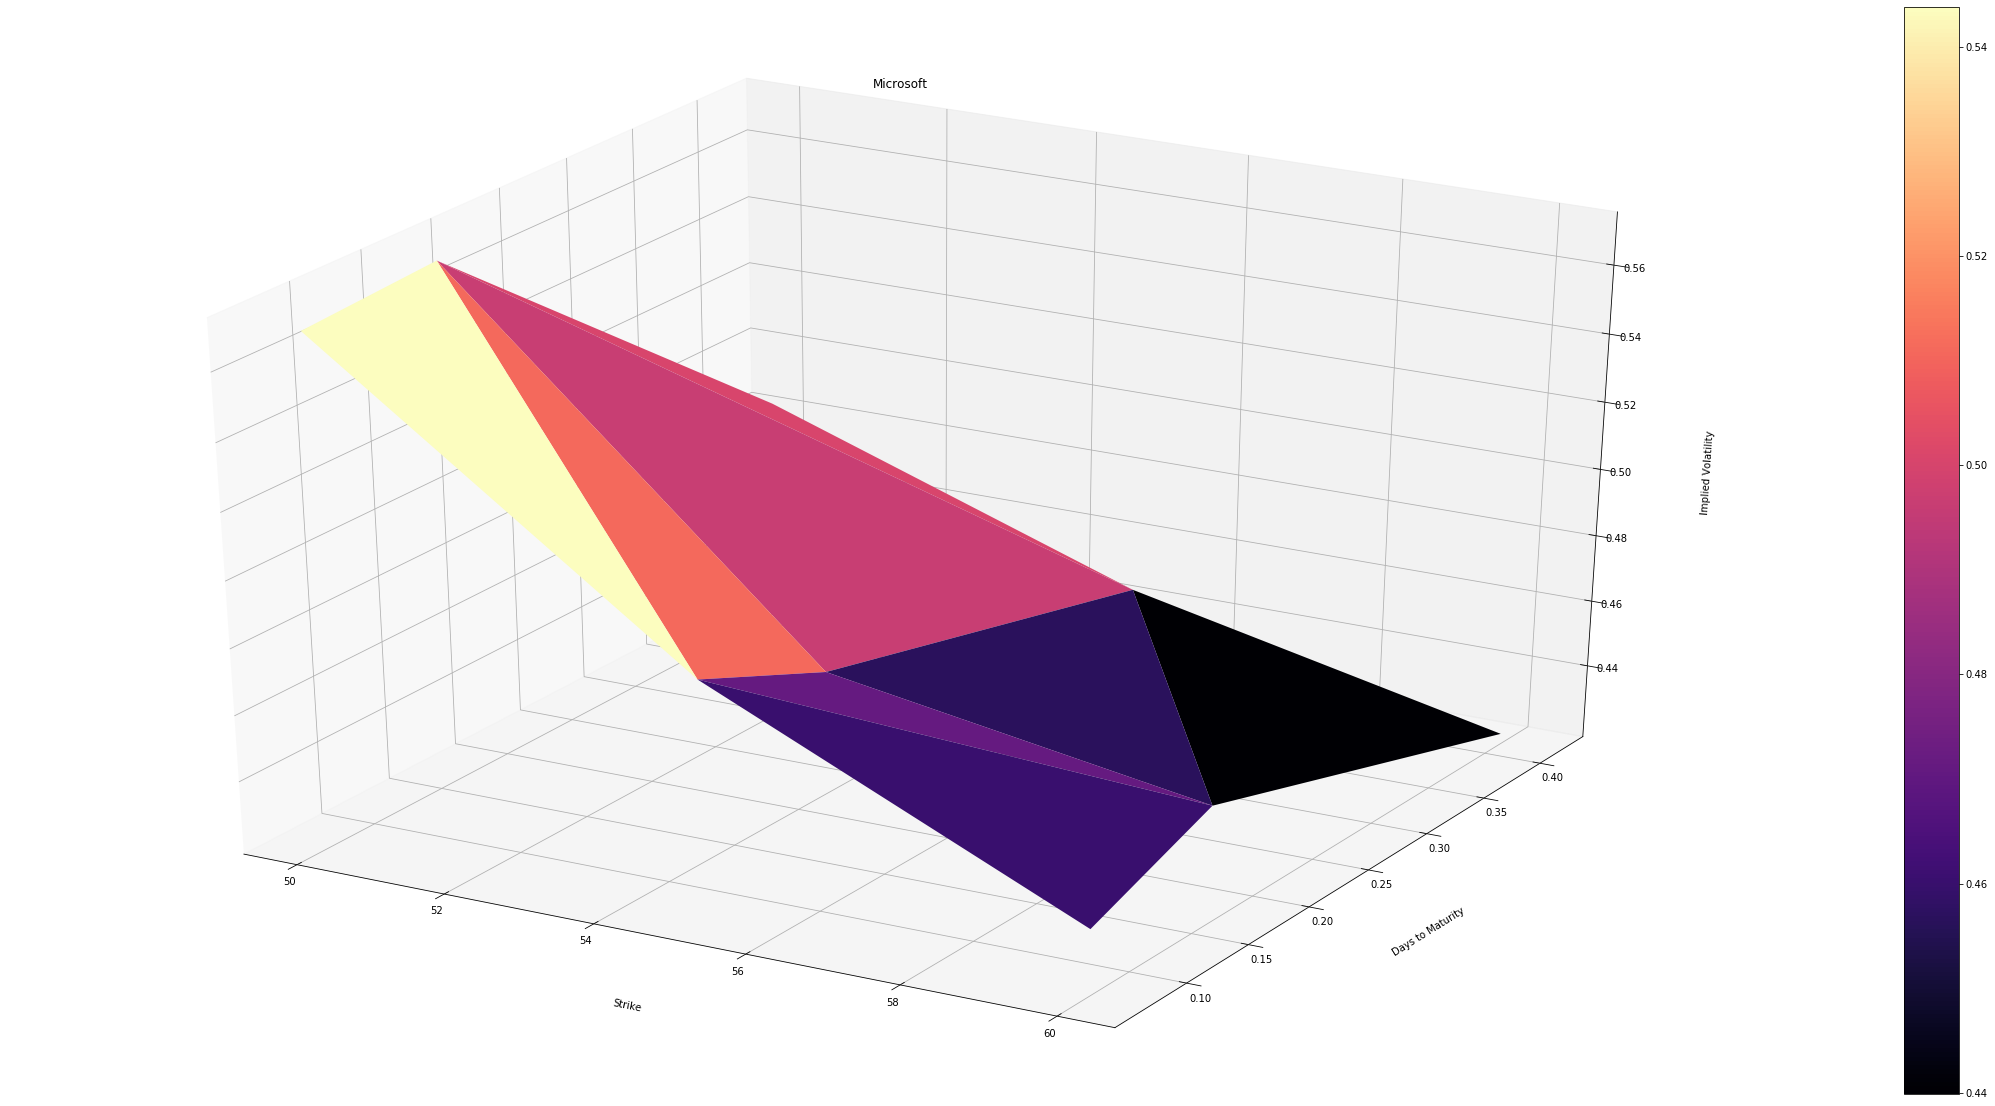

In [46]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

for company in df.Firms.unique():
    call_data = df[(df.Firms == company)]
    fig = plt.figure(figsize=(40,20))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(company)
    surf_1 = ax.plot_trisurf(call_data['Strike'], call_data['Maturity'], 
                    call_data['implied_vol'], label='call', cmap="magma")
    ax.set_xlabel('Strike', labelpad=40)
    ax.set_ylabel('Days to Maturity', labelpad=40)
    ax.set_zlabel('Implied Volatility', labelpad=40)
    surf_1._facecolors2d=surf_1._facecolors3d
    surf_1._edgecolors2d=surf_1._edgecolors3d
    fig.colorbar(surf_1)